# Install and import dependencies

In [1]:
# !pip install rdkit rlmolecule matplotlib

In [2]:
import graphenv
import matplotlib.pyplot as plt
import nfp
import numpy as np
import ray
import rdkit
import rlmolecule
from ray.rllib.utils.framework import try_import_tf
from tqdm import tqdm

print(f"ray: {ray.__version__}")
print(f"graphenv: {graphenv.__version__}")
print(f"nfp: {nfp.__version__}")
print(f"rlmolecule: {rlmolecule.__version__}")

tf1, tf, tfv = try_import_tf()
num_gpus = len(tf.config.list_physical_devices("GPU"))
print(f"Using {num_gpus} GPUs")

%matplotlib inline

ray: 1.13.0
graphenv: 0.1.3
nfp: 0.3.12
rlmolecule: 0.0.5
Using 1 GPUs


# Molecule Builder

In [3]:
from rlmolecule.builder import MoleculeBuilder

The basic functionality adds bonds (and atoms) to a starting molecule

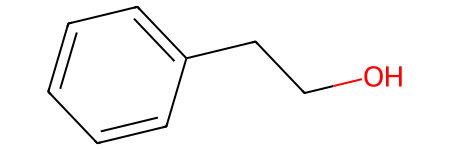

In [4]:
starting_mol = rdkit.Chem.MolFromSmiles("c1ccc(cc1)CCO")
starting_mol

## Basic Functionality

29 derived molecules


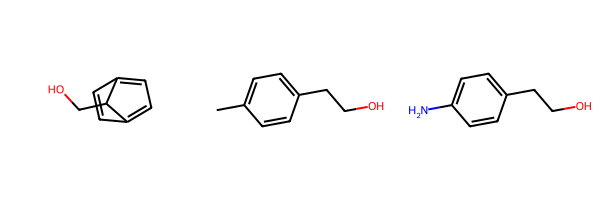

In [5]:
builder = MoleculeBuilder()
next_mols = builder(starting_mol)
print(f"{len(next_mols)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols[:3])

## SA Score Filtering

28 derived molecules


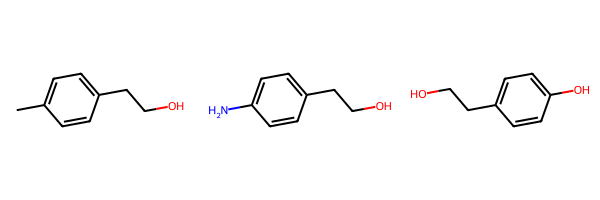

In [6]:
next_mols_sa = MoleculeBuilder(sa_score_threshold=4.0)(starting_mol)
print(f"{len(next_mols_sa)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols_sa[:3])

## Stereochemistry Enumeration

6 derived molecules


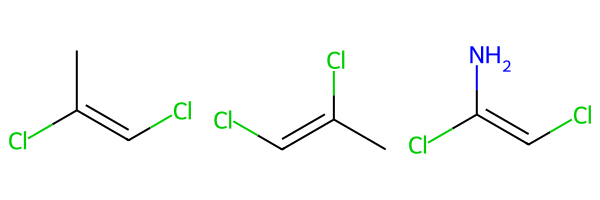

In [7]:
next_mols = MoleculeBuilder(stereoisomers=True)(rdkit.Chem.MolFromSmiles("C(Cl)=C(Cl)"))
print(f"{len(next_mols)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols[:3])

3 derived molecules


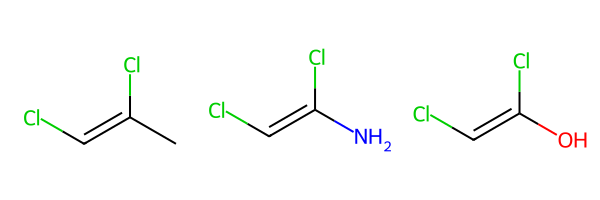

In [8]:
next_mols = MoleculeBuilder(stereoisomers=True)(rdkit.Chem.MolFromSmiles("Cl/C=C\Cl"))
print(f"{len(next_mols)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols[:3])

16 derived molecules


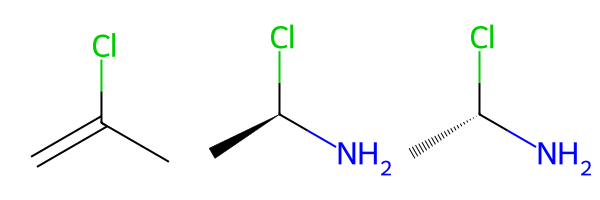

In [9]:
next_mols = MoleculeBuilder(stereoisomers=True)(rdkit.Chem.MolFromSmiles("C(C)(Cl)"))
print(f"{len(next_mols)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols[1:4])

## Tautomer Enumeration

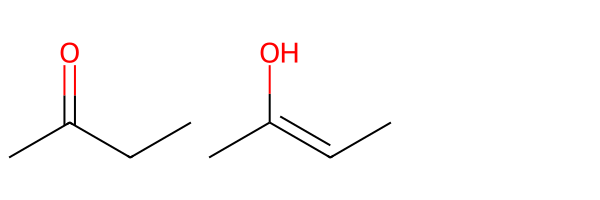

In [10]:
mol1 = rdkit.Chem.MolFromSmiles("CC(CC)=O")
mol2 = rdkit.Chem.MolFromSmiles("CC(O)=CC")
rdkit.Chem.Draw.MolsToGridImage([mol1, mol2])

33 derived molecules


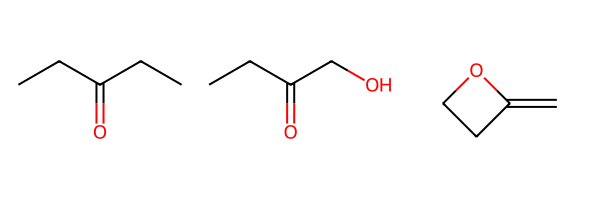

In [11]:
next_mols = MoleculeBuilder(canonicalize_tautomers=True)(
    rdkit.Chem.MolFromSmiles("CC(CC)=O")
)
print(f"{len(next_mols)} derived molecules")
rdkit.Chem.Draw.MolsToGridImage(next_mols[::3][:3])

Next molecules for different forms of the same tautomers are identical

In [12]:
mol1 = rdkit.Chem.MolFromSmiles("CC(CC)=O")
mol2 = rdkit.Chem.MolFromSmiles("CC(O)=CC")

builder = MoleculeBuilder(canonicalize_tautomers=True)
product_smiles = lambda mol: set([rdkit.Chem.MolToSmiles(mol) for mol in builder(mol)])

assert product_smiles(mol1) == product_smiles(mol2)

# MoleculeState
Representing molecules for GNN-based reinforcement learning

In [nfp](https://github.com/NREL/nfp) (and most other GNN libraries) Molecules are represented as integer arrays containing their atom classes, bond classes, and a sparse connectivity matrix

In [13]:
from rlmolecule.policy.preprocessor import load_preprocessor

preprocessor = load_preprocessor()
preprocessor(rdkit.Chem.MolFromSmiles("CCO"))

{'atom': array([ 8, 10, 18]),
 'bond': array([ 3,  3,  9, 10]),
 'connectivity': array([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1]])}

The `MoleculeState` class extends the GraphEnv [`Vertex`](https://nrel.github.io/graph-env/_autosummary/graphenv.vertex.Vertex.html#graphenv.vertex.Vertex) class to combine building next actions and getting the current state's observation matrix. In addition, we must define a *reward* function used to score generated molecules

In [14]:
from rdkit.Chem.QED import qed
from rlmolecule.molecule_state import MoleculeData, MoleculeState


class QEDState(MoleculeState):
    @property
    def reward(self) -> float:
        if self.forced_terminal:
            reward = qed(self.molecule)
            self.data.log_reward([self.smiles, reward])
            return reward

        else:
            return 0.0

`MoleculeBuilder` parameters and other configuration details are stored in a python `dataclass`, which simplifies passing parameter from parent to child `MoleculeState`s

In [15]:
qed_data = MoleculeData(
    MoleculeBuilder(max_atoms=10, cache=True, gdb_filter=False), max_num_actions=32
)

Next states are built lazily upon accessing the `.children` property.

In [16]:
qed_state = QEDState(rdkit.Chem.MolFromSmiles("C"), qed_data)

qed_state.children

[CC, C=C, C#C, CN, C=N, C#N, CO, C=O, C (t)]

In [17]:
qed_state.children[1].children

[C=CC, C=C=C, C=CN, C=C=N, C=CO, C=C=O, C=C (t)]

The final action is typically to return the current molecule as a *terminal* state, i.e. to stop molecule construction and return a reward

In [18]:
terminal_state = qed_state.children[1].children[-1]
terminal_state

C=C (t)

In [19]:
terminal_state.reward

0.34449676855385364

The *observation space* of the molecule state is essentially a padded version of our preprocessed values above, to account for molecule batching

In [20]:
qed_state.observation_space["atom"]

Box([0 0 0 0 0 0 0 0 0 0], [193 193 193 193 193 193 193 193 193 193], (10,), int64)

In [21]:
qed_state.children[0].children[6]  # Ethanol

CCO

In [22]:
qed_state.children[0].children[6].observation["atom"]

array([ 8, 10, 18,  0,  0,  0,  0,  0,  0,  0])

# GraphEnv
The *GraphEnv* batches together molecule states in an OpenAI [gym](https://github.com/openai/gym)-compatible environment 

In [23]:
from graphenv.graph_env import GraphEnv

env = GraphEnv({"state": qed_state, "max_num_children": qed_state.max_num_actions})

In [24]:
# Here, obs is a list of MoleculeState observations, with the first entry corresponding to the parent node
obs = env.reset()

We can randomly sample from possible paths through the environment as follows:

In [25]:
done = False
obs = env.reset()
np.random.seed(0)

while not done:
    action = np.random.choice(len(env.state.children))
    obs, reward, done, info = env.step(action)
    print(env.state)

C#N
CC#N
N#CCN
N#CCN=O
N#CC(=N)N=O
N#CC(=N)N=O (t)


# Molecule Model

Initialized a GNN policy model used to score in-progress molecules. Outputs both a predicted value of the current state, and the likelihood this state should be chosen from a list of next possible states.

https://github.com/NREL/rlmolecule/blob/main/rlmolecule/policy/model.py

In [26]:
from rlmolecule.policy.model import policy_model

In [27]:
model = policy_model()
obs = env.reset()

In [28]:
batched_inputs = {key: np.stack([entry[key] for entry in obs]) for key in obs[0].keys()}

In [29]:
model(batched_inputs)

[<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 0.1023114 ],
        [ 0.02687147],
        [ 0.01532565],
        [-0.02349426],
        [ 0.05053614],
        [ 0.04506102],
        [ 0.0526544 ],
        [-0.01044941],
        [ 0.01468102],
        [ 0.1023114 ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 0.02291128],
        [ 0.01117034],
        [-0.0583286 ],
        [ 0.05579016],
        [ 0.03203445],
        [ 0.00159767],
        [ 0.04150451],
        [ 0.03543371],
        [-0.00952149],
        [ 0.02291128]], dtype=float32)>]

# Running RLLib

A small scale example of running RLLib in the notebook, although longer simulation times are typically required

In [33]:
from ray.tune.registry import register_env
from rlmolecule.molecule_model import MoleculeModel

In [34]:
def create_env(config):
    """When not running in local_mode, there are often issues in allowing ray to copy
    `MoleculeState` to distribute the environment on worker nodes, since actor handles
    are copied and not initialized correctly.
    To solve this, it's best to delay `MoleculeState` (and the dataclass) initialization
    until needed on each ray worker through the `register_env` method.
    Here, we create and return an initialized `GraphEnv` object.
    """

    qed_data = MoleculeData(
        MoleculeBuilder(max_atoms=10, cache=True, gdb_filter=False),
        max_num_actions=32,
        prune_terminal_states=True,
    )

    qed_state = QEDState(
        rdkit.Chem.MolFromSmiles("C"),
        qed_data,
        smiles="C",
    )
    return GraphEnv({"state": qed_state, "max_num_children": qed_state.max_num_actions})


# This registers the above function with rllib, such that we can pass only "QEDGraphEnv"
# as our env object in `tune.run()`
register_env("QEDGraphEnv", lambda config: create_env(config))

In [35]:
from ray.rllib.agents.ppo import PPOTrainer

config = {
    "env": "QEDGraphEnv",
    "model": {
        "custom_model": MoleculeModel,
        "custom_model_config": {
            "preprocessor": load_preprocessor(),
            "features": 32,
            "num_messages": 1,
        },
    },
    "num_workers": 1,
    "num_gpus": 1 if num_gpus >= 1 else 0,
    "framework": "tf2",
    "eager_tracing": True,
    "batch_mode": "complete_episodes",
    "gamma": 1.0,
    "lr": 0.01,
    "entropy_coeff": 0.001,
    "num_sgd_iter": 5,
    "train_batch_size": 100,
    "sgd_minibatch_size": 10,
    "rollout_fragment_length": 100,
}

trainer = PPOTrainer(config=config)

2022-11-22 10:17:44,786	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265
2022-11-22 10:17:51,787	WARNING worker.py:1404 -- It looks like you're creating a detached actor in an anonymous namespace. In order to access this actor in the future, you will need to explicitly connect to this namespace with ray.init(namespace="d8319cb9-6ba4-4dd1-ae6d-827edec4680e", ...)
2022-11-22 10:17:51,793	WARNING worker.py:1404 -- It looks like you're creating a detached actor in an anonymous namespace. In order to access this actor in the future, you will need to explicitly connect to this namespace with ray.init(namespace="d8319cb9-6ba4-4dd1-ae6d-827edec4680e", ...)
(RolloutWorker pid=11334) 2022-11-22 10:17:51,794	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(R

  0%|                                                                                                     | 0/5 [00:00<?, ?it/s](RolloutWorker pid=11334) /home/pstjohn/mambaforge/envs/graphenv/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
(RolloutWorker pid=11334)   ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
2022-11-22 10:17:55,985	WARNING deprecation.py:46 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
2022-11-22 10:17:55,986	WARNING deprecation.py:46 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!
/home/pstjohn/mambaforge/envs/graphenv/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
100%|███████████████████████████████████████████████████████████████████████

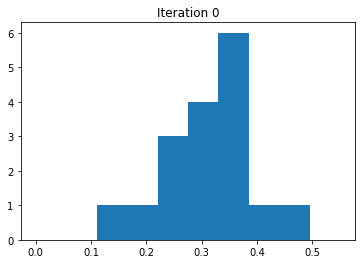

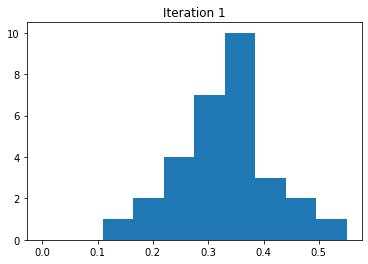

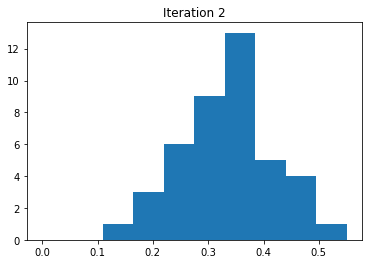

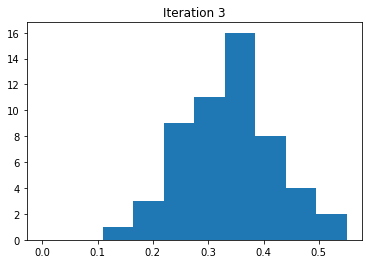

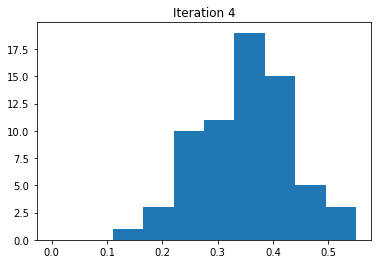

In [36]:
for i in tqdm(range(5)):
    results = trainer.train()

    plt.figure()
    plt.hist(
        np.array(results["sampler_results"]["hist_stats"]["episode_reward"]),
        range=(0, 0.55),
    )
    plt.title(f"Iteration {i}")

# Interrogating a trained policy model

In [37]:
from ray.rllib.models.preprocessors import get_preprocessor

env_preprocessor = get_preprocessor(env.observation_space)(env.observation_space)
policy = trainer.get_policy()
obs = env.reset()

In [38]:
[str(c) for c in env.state.children]

['CC', 'C=C', 'C#C', 'CN', 'C=N', 'C#N', 'CO', 'C=O', 'C (t)']

In [39]:
from typing import Tuple

def get_action_logits(env: GraphEnv) -> dict[str, Tuple[int, float]]:

    obs = env.make_observation()

    logits = policy.model({"obs": env_preprocessor.transform(obs)[None, :]})[0].numpy()[
        0, : len(obs) - 1
    ]

    return {
        str(state): (i, logit)
        for state, (i, logit) in reversed(
            sorted(zip(env.state.children, enumerate(logits)), key=lambda x: x[1][1])
        )
    }

In [40]:
get_action_logits(env)

{'CC': (0, 1.7224407),
 'CN': (3, 0.7325445),
 'C=N': (4, 0.7278897),
 'CO': (6, 0.6338306),
 'C (t)': (8, 0.54776937),
 'C#N': (5, 0.52932316),
 'C#C': (2, 0.4390757),
 'C=C': (1, -0.03240429),
 'C=O': (7, -1.4131068)}

In [41]:
env.step(4)
get_action_logits(env)

{'CC=N': (0, 1.3312994),
 'N=C=N': (3, 1.0778407),
 'C=NC': (6, 0.7655937),
 'C=N (t)': (9, 0.7278897),
 'N=CN': (2, 0.70619076),
 'N=CO': (4, 0.59496146),
 'C=C=N': (1, 0.5642497),
 'N=C=O': (5, 0.055916384),
 'C=NO': (8, 0.039895065),
 'C=NN': (7, 0.029988332)}

In [42]:
env.step(0)
get_action_logits(env)

{'CC(C)=N': (9, 1.6854454),
 'CC=N (t)': (15, 1.3312994),
 'C1=NC1': (0, 1.2919399),
 'CC=NC': (12, 1.2079931),
 'N=CC=N': (5, 1.1144235),
 'CCC=N': (1, 0.9788486),
 'C=CC=N': (2, 0.82681674),
 'N#CC=N': (6, 0.7569006),
 'C#CC=N': (3, 0.70125705),
 'CC=NO': (14, 0.6635575),
 'CC=NN': (13, 0.65612745),
 'N=CCN': (4, 0.5378111),
 'N=CCO': (7, 0.48263243),
 'CC(=N)N': (10, 0.30336678),
 'N=CC=O': (8, -0.01270354),
 'CC(=N)O': (11, -0.28667527)}

In [43]:
env.step(5)
get_action_logits(env)

{'N=c1cn1': (0, 1.556569),
 'N=CC=N (t)': (8, 1.1144235),
 'CN=CC=N': (2, 1.0591536),
 'C1=NN=C1': (1, 1.0305585),
 'CC(=N)C=N': (5, 0.8580132),
 'N=CC=NO': (4, 0.6236051),
 'N=CC=NN': (3, 0.617661),
 'N=CC(=N)N': (6, -0.2476497),
 'N=CC(=N)O': (7, -0.71968323)}

In [44]:
env.state.children[8].reward

0.4054240969465395

# Results for running for ~1hr on a GPU-node
(with a larger maximum molecule size, see https://github.com/NREL/rlmolecule/blob/main/examples/benchmarks/qed/run_qed.py)

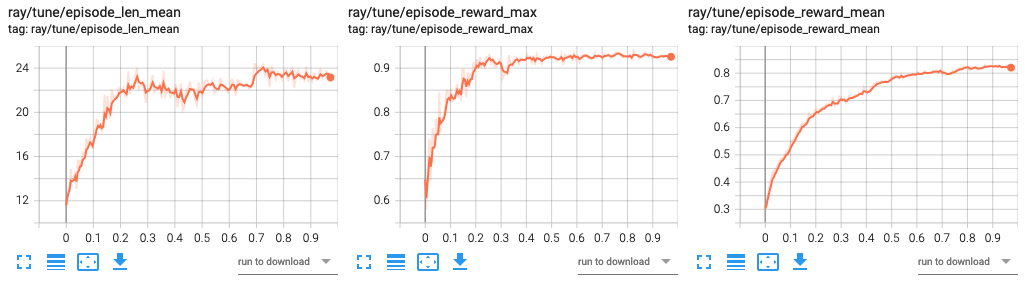